In [2]:
import pickle
import glob
import re
import os
import copy
import subprocess
import timeit
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from functools import reduce

import vcf
import pysam
import numpy as np
import pandas as pd
import dask.dataframe as dd
from Bio import SeqIO
from Bio.SeqUtils import seq1

In [38]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [7]:
reference = SeqIO.read("/home/Users/yl181/wastewater/SARS-CoV-2-reference.fasta", "fasta")
bam_dir = f"/home/Users/yl181/wastewater/processed_data/Read-mapping"
vcf_dir = f"/home/Users/yl181/wastewater/processed_data/Variant-calling-LoFreq"
coverage_dir = f"/home/Users/yl181/wastewater/processed_data/Coverage"

In [19]:
def generate_depth(sorted_bam_f, date, site):
    if not os.path.exists(os.path.join(coverage_dir, f"HHD{date}")):
        os.mkdir(os.path.join(coverage_dir, f"HHD{date}"))
    
    if not os.path.exists(os.path.join(coverage_dir, f"HHD{date}", f"{site}-1")):
        os.mkdir(os.path.join(coverage_dir, f"HHD{date}", f"{site}-1"))
    
    coverage_f = os.path.join(coverage_dir, f"HHD{date}", f"{site}-1", f"{site}-1.clean.sorted.coverage.txt")
    
    os.system(f"samtools depth {sorted_bam_f} > {coverage_f}")

In [157]:
def breadth_coverage(coverage_f, min_dp=100):
    temp_df = pd.read_csv(coverage_f, sep='\t', names=['Gemone_ID', 'POS', 'DP'])
    temp_df.set_index('POS')
    return temp_df[temp_df['DP'] >= min_dp].shape[0]/29903, Counter(temp_df['DP'].to_dict(defaultdict(int)))

In [158]:
count = 0
records = []
sites = set()
pos_dict = Counter()
for sample_date in sorted(os.listdir(bam_dir)):
    date = sample_date[3:]
    for sample_site in sorted(os.listdir(os.path.join(bam_dir, sample_date))):
        site = sample_site.split("-")[0]
        if site != 'NTC' and site != 'PTC':
            sorted_bam_f = os.path.join(bam_dir, f"HHD{date}", f"{site}-1", f"{site}-1.clean.sorted.bam")
            vcf_lofreq_f = os.path.join(vcf_dir, f"HHD{date}", f"{site}-1.clean.vcf")
            coverage_f = os.path.join(coverage_dir, f"HHD{date}", f"{site}-1", f"{site}-1.clean.sorted.coverage.txt")
            if os.path.exists(sorted_bam_f) and os.path.exists(vcf_lofreq_f) and os.path.exists(coverage_f):
                count += 1
                cov, cdict = breadth_coverage(coverage_f)
                records.append({'Date': date, 'Site': site, 'Breadth_Coverage': cov})
                pos_dict = pos_dict + cdict
            
            # if not os.path.exists(coverage_f):
            #     generate_depth(sorted_bam_f, date, site)
                # date_set.add(date)
                # coverage_count += 1

In [159]:
count

3175

In [160]:
coverage_df = pd.DataFrame(records)

In [161]:
coverage_df['Date'] = pd.to_datetime(coverage_df['Date'], format='%m%d%Y')

In [170]:
mean_df = pd.pivot_table(coverage_df, values='Breadth_Coverage', index='Date',
                          aggfunc='mean')

In [172]:
mean_df = mean_df.reset_index()

In [175]:
mean_df

,Date,Breadth_Coverage
0,2021-03-01,0.530705
1,2021-03-15,0.851875
2,2021-03-22,0.773330
3,2021-04-12,0.732330
4,2021-04-19,0.536678
...,...,...
76,2022-10-06,0.038860
77,2022-10-13,0.076505
78,2022-10-20,0.096307
79,2022-10-27,0.105783


In [177]:
mean_df.to_csv('/home/Users/yl181/wastewater/quarc_figures/coverage_df.csv')

(18718.0, 19299.0)

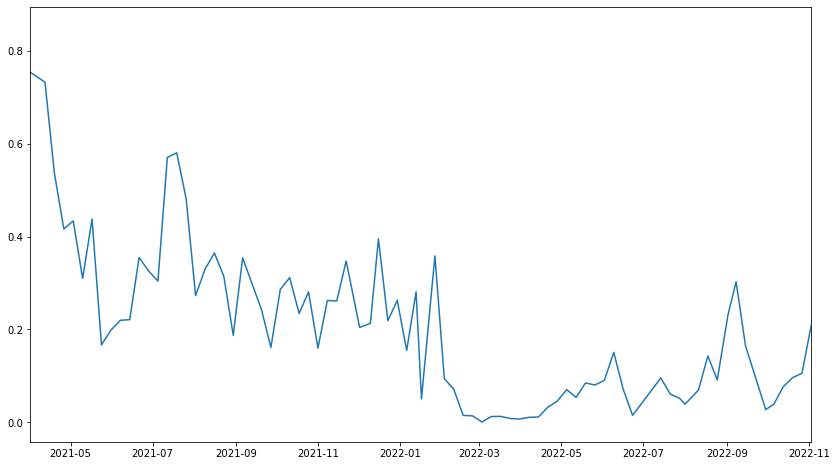

In [176]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(14, 8))

#ax.plot(mean_df['Date'], mean_df['Breadth_Coverage_x']/mean_df['Breadth_Coverage_y'])
ax.plot(mean_df['Date'], mean_df['Breadth_Coverage'])
ax.set_xlim(pd.Timestamp('2021-04-01'), mean_df['Date'].max())

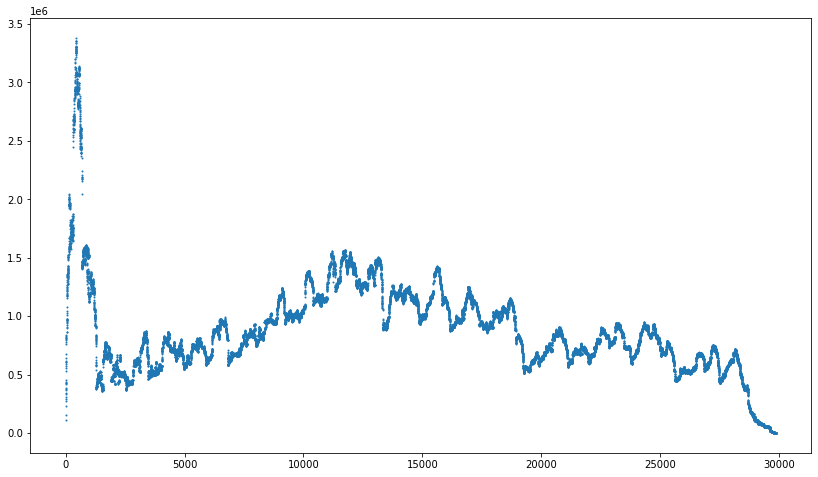

In [169]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(14, 8))

ax.scatter(pos_dict.keys(), pos_dict.values(), s=1)